# Stellar & Nebular Emission - PEGASE

With our Pégase SPS models nebular extinction and continuum emission are essentially built into the stellar emission model.

## Imports

In [2]:
import numpy as np
from scipy.interpolate import interp1d
from lightning.stellar import PEGASEModel as StellarModel
from lightning.sfh import PiecewiseConstSFH
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ebm-dejavu')
%matplotlib inline

## Initialize Model
Here we'll initialize our sort of 'default' stellar population model, which is integrated over stellar age bins to be used with a piecewise-constant SFH. We'll do it twice, with and without the nebular component, to compare.

In [3]:
wave_grid = np.logspace(np.log10(0.01),
                        np.log10(10),
                        200)
filter_labels = ['SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z',
                 'MOIRCS_J', 'MOIRCS_H', 'MOIRCS_Ks',
                 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4']
redshift = 0.0
age = [0, 1e6, 1e8, 1e9, 5e9, 13.6e9]

stars_neb = StellarModel(filter_labels,
                         age=age,
                         redshift=redshift,
                         wave_grid=wave_grid,
                         nebular_effects=True)

stars_noneb = StellarModel(filter_labels,
                           age=age,
                           redshift=redshift,
                           wave_grid=wave_grid,
                           nebular_effects=False)

## Simple Stellar Population Models
We've included the left-hand panel of this plot in basically every `Lightning`-related paper for years.

Text(0.5, 1.0, 'Without Nebula')

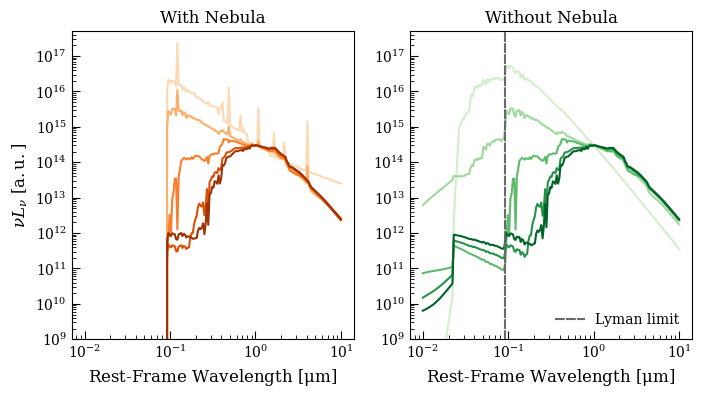

In [4]:
fig, axs = plt.subplots(1,2, figsize=(8,4))

Nmod = len(age) - 1

cm_neb = mpl.colormaps['Oranges']
colors_neb = cm_neb(np.linspace(0.2, 0.9, Nmod))

cm_noneb = mpl.colormaps['Greens']
colors_noneb = cm_noneb(np.linspace(0.2, 0.9, Nmod))

for i in np.arange(Nmod):

    finterp = interp1d(stars_neb.wave_grid_rest, stars_neb.Lnu_obs[i,:])
    f1 = finterp(1)

    axs[0].plot(stars_neb.wave_grid_rest,
                stars_neb.nu_grid_obs * stars_neb.Lnu_obs[i,:] / f1,
                color=colors_neb[i])

    finterp = interp1d(stars_noneb.wave_grid_rest, stars_noneb.Lnu_obs[i,:])
    f1 = finterp(1)

    axs[1].plot(stars_noneb.wave_grid_rest,
                stars_noneb.nu_grid_obs * stars_noneb.Lnu_obs[i,:] / f1,
                color=colors_noneb[i])

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1e9, 5e17)

axs[0].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[0].set_ylabel(r'$\nu L_\nu\ [\rm a.u.]$')
axs[0].set_title('With Nebula')

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(1e9, 5e17)
axs[1].axvline(0.0912, color='dimgray', linestyle='--', label='Lyman limit')
axs[1].legend(loc='lower right')

axs[1].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[1].set_title('Without Nebula')

Where darker shades represent older ages. Note that nebular emission lines are only present for the two models with ages 100 Myr. The effect of free-free nebular continuum emission can be seen by comparing the lightest yellow curve on the left with the lightest green curve on the right.

## Composite Stellar Population Models

To construct composite stellar populations we must of course assume a SFH for the population. Since we binned our simple stellar populations, we must use the `PiecewiseConstantSFH` model.

In [5]:
sfh = PiecewiseConstSFH(age)

Text(0.5, 1.0, 'Without Nebula')

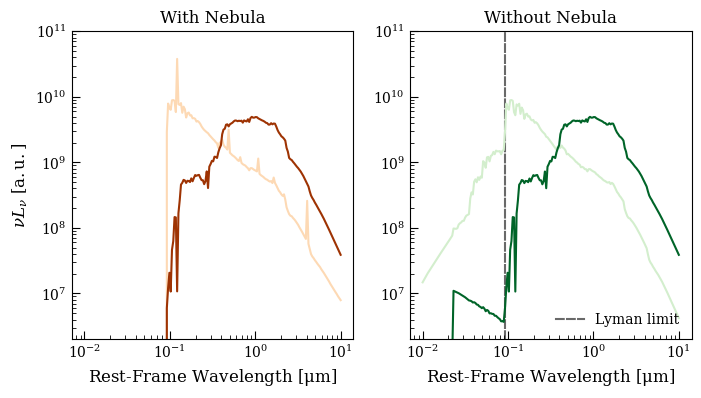

In [15]:
fig, axs = plt.subplots(1,2, figsize=(8,4))

coeffs= np.array([[1,1,0,0,0],
                  [0,0,1,1,1]])

Nmod = coeffs.shape[0]

cm_neb = mpl.colormaps['Oranges']
colors_neb = cm_neb(np.linspace(0.2, 0.9, Nmod))

cm_noneb = mpl.colormaps['Greens']
colors_noneb = cm_noneb(np.linspace(0.2, 0.9, Nmod))

lnu_hires_neb,_,_ = stars_neb.get_model_lnu_hires(sfh, coeffs)
lnu_hires_noneb,_,_ = stars_noneb.get_model_lnu_hires(sfh, coeffs)

for i in np.arange(Nmod):

    axs[0].plot(stars_neb.wave_grid_rest,
                stars_neb.nu_grid_obs * lnu_hires_neb[i,:],
                color=colors_neb[i])

    axs[1].plot(stars_noneb.wave_grid_rest,
                stars_noneb.nu_grid_obs * lnu_hires_noneb[i,:],
                color=colors_noneb[i])

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(2e6, 1e11)

axs[0].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[0].set_ylabel(r'$\nu L_\nu\ [\rm a.u.]$')
axs[0].set_title('With Nebula')

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(2e6, 1e11)
axs[1].axvline(0.0912, color='dimgray', linestyle='--', label='Lyman limit', zorder=-1)
axs[1].legend(loc='lower right')

axs[1].set_xlabel(r'Rest-Frame Wavelength [$\rm \mu m$]')
axs[1].set_title('Without Nebula')


Here the lighter colored populations are star forming, and the darker ones are quiescent. Note that even if you were to use stellar populations without nebular extinction for your SED fitting in Lightning, the resulting galaxy would have no Lyman continuum leakage, as our ISM attenuation models are defined to be opaque to Lyman continuum radiation.